# Calcul d'EOF avec la librairie eofs.standard

Il faut télécharger le module python/gloesmfpy puis le kernel gloesmfpy
Documentation : https://ajdawson.github.io/eofs/latest/index.html

## Choose the kernel gloesmfpy
module load python/gloesmfpy 

In [1]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from eofs.standard import Eof

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.path as mpath
from sklearn.cluster import KMeans

**ouverture des données:** remplace filename par vos anomalies calculé, attention changer le domaine spatio temporel changeras les regimes !!

In [2]:
filename = '/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/psl_anom_atl_winter_piControl_1850_2849.nc'
data = xr.open_dataset(filename, use_cftime=True)
lons = data.lon.values
lats = data.lat.values
dates = data.time.values

filename = '/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/psl_atl_winter_piControl_1850_2849.nc'
data0 = xr.open_dataset(filename, use_cftime=True, drop_variables = 'time_bounds')


# ----------------------- Calcul des EOFs -----------------------

In [3]:
wgts = np.sqrt(np.cos(np.deg2rad(lats)))[:, np.newaxis] ### On doit mettre un poid pour chaques latitudes

**Calcule des EOFs**

In [4]:
solver = Eof(data.psl.values, weights=wgts, center=True)

In [5]:
n=15
eofs = solver.eofs(neofs=n, eofscaling=1)
pcs = solver.pcs(npcs=n, pcscaling=0)
pcs_norm = solver.pcs(npcs=n, pcscaling=1)
varfrac = solver.varianceFraction()
print("% de variance expliquée par les 10 premiers EOFs : ", 100*varfrac[0:10].sum())

% de variance expliquée par les 10 premiers EOFs :  83.30801781948234


**programe pour plot**

In [6]:
latS=20
latN=80
lonW=-80
lonE=30

projection = ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2)

def make_boundary_path(lon,lat):
    lons,lats=np.meshgrid(lon,lat)
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

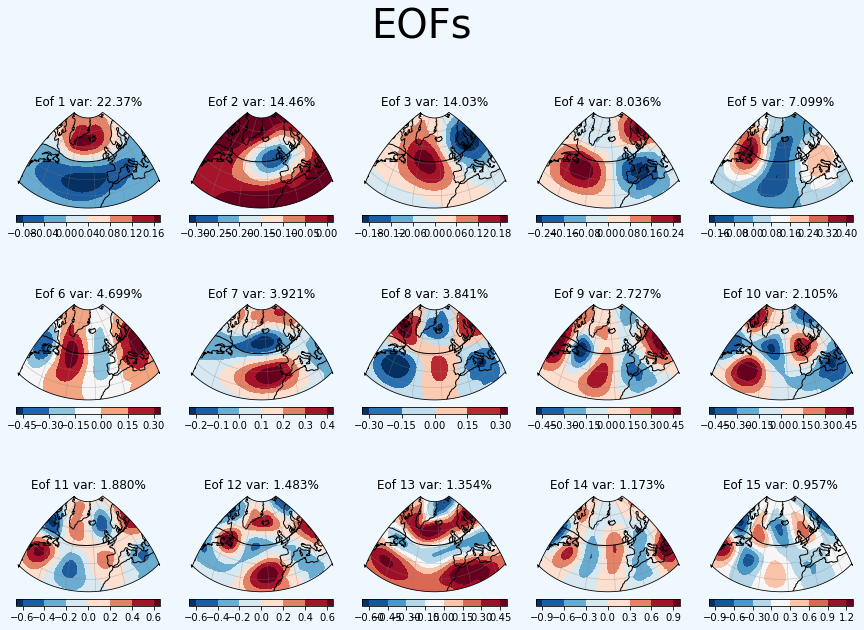

In [7]:
fig = plt.figure(figsize=(15, 10),  facecolor='aliceblue')
fig.suptitle('EOFs', fontsize=40)
for i in range(15):
    ax = fig.add_subplot(3,5,i+1, projection=projection)
    ax.set_title('Eof '+str(i+1)+' var: '+str(varfrac[i]*100)[:5]+'%', loc='center')
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='grey', alpha=0.5, linestyle='-')
    boundary_path = make_boundary_path(lons, lats)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    p1 = ax.contourf(lons, lats, eofs[i]*1e5,  transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
    ax.contour(lons, lats, eofs[0]*1e5, np.linspace(-16, 16, 9), colors='black', linewidths=1, transform=ccrs.PlateCarree())
    cb = fig.colorbar(p1, orientation='horizontal', aspect=20, shrink=1, pad=0.05, extendrect='True')

#  ----------------------- Clustering: Algorythme Kmeans -----------------------

**runing the Kmeans algorythme on the pcs**

more info here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [8]:
n_init=100
max_iter=500


kmeans = KMeans(n_clusters=4, n_init=n_init, max_iter=max_iter, algorithm="full", verbose=1)
# Getting the cluster labels
cluster = kmeans.fit_predict(pcs)
# Centroid values
centroids = kmeans.cluster_centers_

print(cluster)
print(cluster.shape)
print(centroids.shape)

Initialization complete
Iteration 0, inertia 301415117739768.94.
Iteration 1, inertia 194704869492473.78.
Iteration 2, inertia 191099067982012.34.
Iteration 3, inertia 190322644698964.16.
Iteration 4, inertia 190036228420139.8.
Iteration 5, inertia 189890314202399.94.
Iteration 6, inertia 189798062574497.3.
Iteration 7, inertia 189725763574610.47.
Iteration 8, inertia 189666518090572.2.
Iteration 9, inertia 189613940415974.38.
Iteration 10, inertia 189564531874359.7.
Iteration 11, inertia 189514202058139.44.
Iteration 12, inertia 189468863036469.84.
Iteration 13, inertia 189427357529446.16.
Iteration 14, inertia 189388578233949.22.
Iteration 15, inertia 189352541530154.56.
Iteration 16, inertia 189314740064755.4.
Iteration 17, inertia 189280675373000.12.
Iteration 18, inertia 189251193060460.75.
Iteration 19, inertia 189222833971575.0.
Iteration 20, inertia 189195680089547.97.
Iteration 21, inertia 189171743991613.34.
Iteration 22, inertia 189150456625498.88.
Iteration 23, inertia 1891

Iteration 103, inertia 188990881461535.97.
Iteration 104, inertia 188986364585958.75.
Iteration 105, inertia 188981694734342.5.
Iteration 106, inertia 188976877423685.56.
Iteration 107, inertia 188972491842877.06.
Iteration 108, inertia 188968902875825.97.
Iteration 109, inertia 188965472332513.53.
Iteration 110, inertia 188962493121878.44.
Iteration 111, inertia 188959579031022.94.
Iteration 112, inertia 188957016234560.3.
Iteration 113, inertia 188954226721818.22.
Iteration 114, inertia 188950991416449.38.
Iteration 115, inertia 188947519878110.9.
Iteration 116, inertia 188944258971304.16.
Iteration 117, inertia 188941450513422.97.
Iteration 118, inertia 188938607719211.4.
Iteration 119, inertia 188936079008731.94.
Iteration 120, inertia 188934123506878.1.
Iteration 121, inertia 188932581925846.94.
Iteration 122, inertia 188931104443659.06.
Iteration 123, inertia 188929942963634.78.
Iteration 124, inertia 188928688463491.66.
Iteration 125, inertia 188927186316448.88.
Iteration 126, i

Iteration 0, inertia 298348290003375.75.
Iteration 1, inertia 205079934313222.1.
Iteration 2, inertia 196321892252258.0.
Iteration 3, inertia 193357533074831.75.
Iteration 4, inertia 191976858726473.4.
Iteration 5, inertia 191211120507938.25.
Iteration 6, inertia 190694638296268.22.
Iteration 7, inertia 190360879895665.56.
Iteration 8, inertia 190132997832403.84.
Iteration 9, inertia 189955066415539.9.
Iteration 10, inertia 189803541731472.44.
Iteration 11, inertia 189675051509395.75.
Iteration 12, inertia 189567672755357.94.
Iteration 13, inertia 189476134575836.53.
Iteration 14, inertia 189397935111980.03.
Iteration 15, inertia 189330572941797.66.
Iteration 16, inertia 189271846322145.4.
Iteration 17, inertia 189220300579006.88.
Iteration 18, inertia 189176929372518.6.
Iteration 19, inertia 189140626410013.2.
Iteration 20, inertia 189110221833857.3.
Iteration 21, inertia 189083420323846.56.
Iteration 22, inertia 189060408389324.62.
Iteration 23, inertia 189041835311298.28.
Iteration 

Iteration 79, inertia 188924498369723.03.
Iteration 80, inertia 188922903503216.75.
Iteration 81, inertia 188921387175242.62.
Iteration 82, inertia 188919734818061.66.
Iteration 83, inertia 188917954218249.75.
Iteration 84, inertia 188916384266169.06.
Iteration 85, inertia 188914976201491.1.
Iteration 86, inertia 188913616108267.75.
Iteration 87, inertia 188912332114593.78.
Iteration 88, inertia 188911213491609.28.
Iteration 89, inertia 188909747432769.9.
Iteration 90, inertia 188908270413896.97.
Iteration 91, inertia 188906612592731.7.
Iteration 92, inertia 188905144800879.84.
Iteration 93, inertia 188903772747549.78.
Iteration 94, inertia 188902736300962.8.
Iteration 95, inertia 188901764457543.5.
Iteration 96, inertia 188900891299704.94.
Converged at iteration 96: center shift 10874.07621798242 within tolerance 14575.967254528272.
Initialization complete
Iteration 0, inertia 289786415574707.5.
Iteration 1, inertia 201963409157094.88.
Iteration 2, inertia 195094942734043.1.
Iteration

Iteration 112, inertia 189079794721451.8.
Iteration 113, inertia 189066290246627.4.
Iteration 114, inertia 189052720924717.62.
Iteration 115, inertia 189040093999373.66.
Iteration 116, inertia 189029527492451.88.
Iteration 117, inertia 189020896236698.6.
Iteration 118, inertia 189012719891865.7.
Iteration 119, inertia 189005000223282.1.
Iteration 120, inertia 188996943452230.66.
Iteration 121, inertia 188989077648147.78.
Iteration 122, inertia 188981165463157.62.
Iteration 123, inertia 188973815492268.47.
Iteration 124, inertia 188966801458198.3.
Iteration 125, inertia 188960396246278.2.
Iteration 126, inertia 188954966034986.88.
Iteration 127, inertia 188950516713292.72.
Iteration 128, inertia 188946356107091.25.
Iteration 129, inertia 188942088201539.97.
Iteration 130, inertia 188937602711232.94.
Iteration 131, inertia 188933179901514.4.
Iteration 132, inertia 188929455373542.12.
Iteration 133, inertia 188926064490589.88.
Iteration 134, inertia 188921786107790.9.
Iteration 135, inert

Initialization complete
Iteration 0, inertia 296168035944731.7.
Iteration 1, inertia 193853090496420.0.
Iteration 2, inertia 191047867382471.25.
Iteration 3, inertia 190386796531426.28.
Iteration 4, inertia 190084673155334.75.
Iteration 5, inertia 189894010369124.34.
Iteration 6, inertia 189744556969454.28.
Iteration 7, inertia 189612337134773.5.
Iteration 8, inertia 189504410257081.0.
Iteration 9, inertia 189418467868002.22.
Iteration 10, inertia 189345884154352.94.
Iteration 11, inertia 189280689574189.34.
Iteration 12, inertia 189220927581830.56.
Iteration 13, inertia 189167952227769.84.
Iteration 14, inertia 189121662916801.47.
Iteration 15, inertia 189083493411787.2.
Iteration 16, inertia 189048659343091.2.
Iteration 17, inertia 189018714009428.1.
Iteration 18, inertia 188995974900497.7.
Iteration 19, inertia 188979133906854.06.
Iteration 20, inertia 188965114588419.47.
Iteration 21, inertia 188954018357142.1.
Iteration 22, inertia 188945119593159.94.
Iteration 23, inertia 1889375

Iteration 106, inertia 188941628875740.88.
Iteration 107, inertia 188937124015584.97.
Iteration 108, inertia 188932747541332.16.
Iteration 109, inertia 188929139911872.75.
Iteration 110, inertia 188925624086006.84.
Iteration 111, inertia 188921370544587.2.
Iteration 112, inertia 188917977468018.78.
Iteration 113, inertia 188914799762390.66.
Iteration 114, inertia 188912000389781.06.
Iteration 115, inertia 188909655057253.38.
Iteration 116, inertia 188907362011703.88.
Iteration 117, inertia 188904971896210.84.
Iteration 118, inertia 188903021986729.06.
Iteration 119, inertia 188901668634749.0.
Iteration 120, inertia 188900619623216.88.
Converged at iteration 120: center shift 14506.553342849435 within tolerance 14575.967254528272.
Initialization complete
Iteration 0, inertia 292871814975200.1.
Iteration 1, inertia 199575012177778.3.
Iteration 2, inertia 196580143404942.38.
Iteration 3, inertia 194133467288536.62.
Iteration 4, inertia 192107941742599.47.
Iteration 5, inertia 191185016489

Iteration 0, inertia 312489151685797.44.
Iteration 1, inertia 199255816521635.28.
Iteration 2, inertia 192956496089350.75.
Iteration 3, inertia 191184157703206.56.
Iteration 4, inertia 190454327027151.25.
Iteration 5, inertia 190105105155525.84.
Iteration 6, inertia 189903992694258.7.
Iteration 7, inertia 189770462272422.38.
Iteration 8, inertia 189680581237236.56.
Iteration 9, inertia 189613119723030.28.
Iteration 10, inertia 189558638807806.38.
Iteration 11, inertia 189513754615782.0.
Iteration 12, inertia 189472724204764.75.
Iteration 13, inertia 189440894781381.44.
Iteration 14, inertia 189415031702021.34.
Iteration 15, inertia 189392948474729.38.
Iteration 16, inertia 189375743189241.88.
Iteration 17, inertia 189360067713887.88.
Iteration 18, inertia 189347799189330.9.
Iteration 19, inertia 189335776760538.53.
Iteration 20, inertia 189324907007034.16.
Iteration 21, inertia 189315902484344.38.
Iteration 22, inertia 189308286160160.25.
Iteration 23, inertia 189301806878191.8.
Iterat

Iteration 18, inertia 189303502535637.78.
Iteration 19, inertia 189297712254341.34.
Iteration 20, inertia 189292818798341.62.
Iteration 21, inertia 189288544073933.25.
Iteration 22, inertia 189285279174721.47.
Iteration 23, inertia 189283082809634.88.
Iteration 24, inertia 189281282617226.7.
Iteration 25, inertia 189279727012020.6.
Iteration 26, inertia 189278369257737.75.
Iteration 27, inertia 189277458509345.22.
Converged at iteration 27: center shift 13843.757546163368 within tolerance 14575.967254528272.
Initialization complete
Iteration 0, inertia 310155982021962.94.
Iteration 1, inertia 200273516604025.1.
Iteration 2, inertia 193712846424520.4.
Iteration 3, inertia 191665197121155.88.
Iteration 4, inertia 190994186219499.03.
Iteration 5, inertia 190705623948691.9.
Iteration 6, inertia 190532133558162.53.
Iteration 7, inertia 190393674382128.56.
Iteration 8, inertia 190273515037802.4.
Iteration 9, inertia 190168940427766.38.
Iteration 10, inertia 190080112145481.97.
Iteration 11, 

Iteration 0, inertia 289243213112016.25.
Iteration 1, inertia 207289070112902.4.
Iteration 2, inertia 196116769999744.97.
Iteration 3, inertia 193688460292454.44.
Iteration 4, inertia 191980220760143.5.
Iteration 5, inertia 190617936588296.97.
Iteration 6, inertia 189824300963190.94.
Iteration 7, inertia 189456486703736.16.
Iteration 8, inertia 189308241191493.8.
Iteration 9, inertia 189248183835198.34.
Iteration 10, inertia 189218694815667.12.
Iteration 11, inertia 189196500630350.1.
Iteration 12, inertia 189179685731708.62.
Iteration 13, inertia 189163978296026.62.
Iteration 14, inertia 189148686475042.38.
Iteration 15, inertia 189133545412089.25.
Iteration 16, inertia 189118469241533.06.
Iteration 17, inertia 189103925672819.7.
Iteration 18, inertia 189089446051650.38.
Iteration 19, inertia 189075405290940.72.
Iteration 20, inertia 189061951343295.22.
Iteration 21, inertia 189048433567328.22.
Iteration 22, inertia 189036174798249.47.
Iteration 23, inertia 189025502707445.16.
Iterati

Iteration 55, inertia 188914399527634.53.
Iteration 56, inertia 188913144408205.84.
Iteration 57, inertia 188912011027931.25.
Iteration 58, inertia 188910881711449.1.
Iteration 59, inertia 188909321109065.34.
Iteration 60, inertia 188907834680565.3.
Iteration 61, inertia 188906178706130.53.
Iteration 62, inertia 188904720965436.38.
Iteration 63, inertia 188903473735205.66.
Iteration 64, inertia 188902480599599.75.
Iteration 65, inertia 188901583819137.34.
Converged at iteration 65: center shift 14566.103623036206 within tolerance 14575.967254528272.
Initialization complete
Iteration 0, inertia 288732107537383.0.
Iteration 1, inertia 200893414511752.8.
Iteration 2, inertia 197959795060933.53.
Iteration 3, inertia 196163823723670.9.
Iteration 4, inertia 194735959482472.2.
Iteration 5, inertia 193573943749657.38.
Iteration 6, inertia 192561596746390.38.
Iteration 7, inertia 191640477402587.88.
Iteration 8, inertia 190884841836687.22.
Iteration 9, inertia 190404033100415.7.
Iteration 10, i

Iteration 0, inertia 281429818362658.03.
Iteration 1, inertia 195818729333306.6.
Iteration 2, inertia 191360930143092.56.
Iteration 3, inertia 190397158859759.03.
Iteration 4, inertia 190001754850885.5.
Iteration 5, inertia 189779365800240.4.
Iteration 6, inertia 189630542405101.7.
Iteration 7, inertia 189518047336246.94.
Iteration 8, inertia 189427776755837.72.
Iteration 9, inertia 189355504719137.44.
Iteration 10, inertia 189292940742920.62.
Iteration 11, inertia 189241117131415.5.
Iteration 12, inertia 189198801153960.97.
Iteration 13, inertia 189162486868123.97.
Iteration 14, inertia 189130963473640.16.
Iteration 15, inertia 189104461561552.1.
Iteration 16, inertia 189081507221785.22.
Iteration 17, inertia 189061633246539.88.
Iteration 18, inertia 189043199995547.53.
Iteration 19, inertia 189024507336415.12.
Iteration 20, inertia 189007839663589.0.
Iteration 21, inertia 188993925255587.06.
Iteration 22, inertia 188980829054904.75.
Iteration 23, inertia 188969577403460.53.
Iteration

Iteration 101, inertia 188958753852581.78.
Iteration 102, inertia 188956226351229.44.
Iteration 103, inertia 188953248042843.03.
Iteration 104, inertia 188949910474130.7.
Iteration 105, inertia 188946606383087.78.
Iteration 106, inertia 188943505215390.16.
Iteration 107, inertia 188940457977287.53.
Iteration 108, inertia 188937443996477.0.
Iteration 109, inertia 188935157937998.94.
Iteration 110, inertia 188933437898806.38.
Iteration 111, inertia 188932089865547.0.
Iteration 112, inertia 188930602911279.34.
Iteration 113, inertia 188929384597354.5.
Iteration 114, inertia 188928088460393.94.
Iteration 115, inertia 188926370241240.62.
Iteration 116, inertia 188924504622925.72.
Iteration 117, inertia 188922903503216.75.
Iteration 118, inertia 188921387175242.6.
Iteration 119, inertia 188919734818061.62.
Iteration 120, inertia 188917954218249.75.
Iteration 121, inertia 188916384266169.06.
Iteration 122, inertia 188914976201491.12.
Iteration 123, inertia 188913616108267.75.
Iteration 124, i

Iteration 3, inertia 191033767432239.1.
Iteration 4, inertia 190037436142143.44.
Iteration 5, inertia 189587155033489.5.
Iteration 6, inertia 189392884593746.44.
Iteration 7, inertia 189291132785466.12.
Iteration 8, inertia 189228874475142.7.
Iteration 9, inertia 189184934697621.47.
Iteration 10, inertia 189150159547643.03.
Iteration 11, inertia 189118047843486.44.
Iteration 12, inertia 189091258689774.06.
Iteration 13, inertia 189066191836575.53.
Iteration 14, inertia 189044650921969.97.
Iteration 15, inertia 189024967713244.88.
Iteration 16, inertia 189009465771482.97.
Iteration 17, inertia 188995379996947.56.
Iteration 18, inertia 188983263359013.88.
Iteration 19, inertia 188972225890124.7.
Iteration 20, inertia 188959231943114.8.
Iteration 21, inertia 188946941456345.97.
Iteration 22, inertia 188936102801910.03.
Iteration 23, inertia 188928256273143.16.
Iteration 24, inertia 188922287999566.62.
Iteration 25, inertia 188917108652025.28.
Iteration 26, inertia 188912110445403.34.
Iter

Iteration 0, inertia 289085119842452.3.
Iteration 1, inertia 203799016589989.7.
Iteration 2, inertia 197411329325621.06.
Iteration 3, inertia 193769978796786.34.
Iteration 4, inertia 191708463157992.28.
Iteration 5, inertia 190743036439645.88.
Iteration 6, inertia 190314685248963.06.
Iteration 7, inertia 190117441069656.6.
Iteration 8, inertia 190021160346945.72.
Iteration 9, inertia 189966968628276.9.
Iteration 10, inertia 189927407570415.4.
Iteration 11, inertia 189895925534759.22.
Iteration 12, inertia 189868767903067.78.
Iteration 13, inertia 189845646982183.97.
Iteration 14, inertia 189826999444939.94.
Iteration 15, inertia 189810179218905.25.
Iteration 16, inertia 189793949314170.5.
Iteration 17, inertia 189778200712719.8.
Iteration 18, inertia 189763630250263.5.
Iteration 19, inertia 189750655811595.2.
Iteration 20, inertia 189739152901237.94.
Iteration 21, inertia 189728734681897.7.
Iteration 22, inertia 189719935772530.12.
Iteration 23, inertia 189712550626831.56.
Iteration 24

Iteration 14, inertia 189619667673711.6.
Iteration 15, inertia 189569996663594.16.
Iteration 16, inertia 189523538961607.8.
Iteration 17, inertia 189481267393039.03.
Iteration 18, inertia 189442162252984.84.
Iteration 19, inertia 189403240092442.88.
Iteration 20, inertia 189367207540043.75.
Iteration 21, inertia 189333564444326.62.
Iteration 22, inertia 189303376403383.62.
Iteration 23, inertia 189277692007286.16.
Iteration 24, inertia 189255170792660.28.
Iteration 25, inertia 189234380069814.3.
Iteration 26, inertia 189215563392239.8.
Iteration 27, inertia 189199364788515.4.
Iteration 28, inertia 189183496425729.56.
Iteration 29, inertia 189168675926980.88.
Iteration 30, inertia 189153750192374.03.
Iteration 31, inertia 189139809340790.5.
Iteration 32, inertia 189126313264750.94.
Iteration 33, inertia 189114804007609.4.
Iteration 34, inertia 189104698042538.12.
Iteration 35, inertia 189095560368786.9.
Iteration 36, inertia 189087327919787.78.
Iteration 37, inertia 189078684773707.97.


Iteration 4, inertia 191645219096381.06.
Iteration 5, inertia 190560196469477.3.
Iteration 6, inertia 190076855793973.12.
Iteration 7, inertia 189822944175382.8.
Iteration 8, inertia 189667386049052.78.
Iteration 9, inertia 189554897705926.44.
Iteration 10, inertia 189472754608729.3.
Iteration 11, inertia 189403988556118.1.
Iteration 12, inertia 189345499176705.0.
Iteration 13, inertia 189296288132059.06.
Iteration 14, inertia 189256625085821.62.
Iteration 15, inertia 189226528228346.28.
Iteration 16, inertia 189203294685182.25.
Iteration 17, inertia 189185872844959.97.
Iteration 18, inertia 189170037803815.1.
Iteration 19, inertia 189155034342469.38.
Iteration 20, inertia 189141384936073.62.
Iteration 21, inertia 189129145738641.2.
Iteration 22, inertia 189117832327790.56.
Iteration 23, inertia 189107429397745.66.
Iteration 24, inertia 189097910151622.9.
Iteration 25, inertia 189089536597675.0.
Iteration 26, inertia 189080539104357.8.
Iteration 27, inertia 189071437316014.94.
Iteratio

Iteration 0, inertia 314700273190207.1.
Iteration 1, inertia 195390204100714.97.
Iteration 2, inertia 191455813534358.3.
Iteration 3, inertia 190651345139532.7.
Iteration 4, inertia 190363143701739.7.
Iteration 5, inertia 190185316801301.3.
Iteration 6, inertia 190048581150557.7.
Iteration 7, inertia 189927343725620.22.
Iteration 8, inertia 189815927945507.5.
Iteration 9, inertia 189707594521744.47.
Iteration 10, inertia 189606287834017.66.
Iteration 11, inertia 189512746216398.56.
Iteration 12, inertia 189425475301735.56.
Iteration 13, inertia 189344354299503.4.
Iteration 14, inertia 189276473305737.38.
Iteration 15, inertia 189211484319335.25.
Iteration 16, inertia 189155580372034.7.
Iteration 17, inertia 189109165628618.3.
Iteration 18, inertia 189069538056813.8.
Iteration 19, inertia 189036789373376.38.
Iteration 20, inertia 189011354498244.12.
Iteration 21, inertia 188990501301401.2.
Iteration 22, inertia 188973821977334.16.
Iteration 23, inertia 188959589038458.56.
Iteration 24, 

Iteration 12, inertia 190490410389924.06.
Iteration 13, inertia 190283463621772.12.
Iteration 14, inertia 190133012976080.7.
Iteration 15, inertia 190010829994855.03.
Iteration 16, inertia 189902362347700.25.
Iteration 17, inertia 189805271811766.5.
Iteration 18, inertia 189720069578102.84.
Iteration 19, inertia 189646609706269.2.
Iteration 20, inertia 189581455992866.47.
Iteration 21, inertia 189524422468326.4.
Iteration 22, inertia 189474169911136.25.
Iteration 23, inertia 189433825318936.22.
Iteration 24, inertia 189399619624889.75.
Iteration 25, inertia 189372010630223.47.
Iteration 26, inertia 189348307852411.66.
Iteration 27, inertia 189327487991515.4.
Iteration 28, inertia 189310040691651.4.
Iteration 29, inertia 189293875669246.72.
Iteration 30, inertia 189279652661044.75.
Iteration 31, inertia 189266575299893.38.
Iteration 32, inertia 189255942575342.88.
Iteration 33, inertia 189246757937841.97.
Iteration 34, inertia 189239033778395.78.
Iteration 35, inertia 189232590979490.4.

Iteration 12, inertia 189316188310904.25.
Iteration 13, inertia 189304290955057.1.
Iteration 14, inertia 189293020396635.53.
Iteration 15, inertia 189282503332823.2.
Iteration 16, inertia 189270963408272.1.
Iteration 17, inertia 189259383911098.16.
Iteration 18, inertia 189246836611443.12.
Iteration 19, inertia 189235250494011.16.
Iteration 20, inertia 189223928312773.8.
Iteration 21, inertia 189213509813892.16.
Iteration 22, inertia 189201909157322.22.
Iteration 23, inertia 189190257673309.2.
Iteration 24, inertia 189179092338731.44.
Iteration 25, inertia 189167229615793.72.
Iteration 26, inertia 189154851556451.06.
Iteration 27, inertia 189141931943614.12.
Iteration 28, inertia 189128865712237.8.
Iteration 29, inertia 189114925669324.2.
Iteration 30, inertia 189100175198890.66.
Iteration 31, inertia 189086181028808.8.
Iteration 32, inertia 189073029615589.22.
Iteration 33, inertia 189059012984420.94.
Iteration 34, inertia 189046500350749.0.
Iteration 35, inertia 189034973149114.06.
I

Iteration 106, inertia 189508096372107.44.
Iteration 107, inertia 189498419068940.5.
Iteration 108, inertia 189489289280611.88.
Iteration 109, inertia 189480319963319.8.
Iteration 110, inertia 189471783397429.62.
Iteration 111, inertia 189462567417629.16.
Iteration 112, inertia 189453451065818.56.
Iteration 113, inertia 189443353047479.94.
Iteration 114, inertia 189431796449610.56.
Iteration 115, inertia 189419680404102.25.
Iteration 116, inertia 189408874183701.84.
Iteration 117, inertia 189399769600331.2.
Iteration 118, inertia 189391875290937.84.
Iteration 119, inertia 189384351439028.62.
Iteration 120, inertia 189377280011459.5.
Iteration 121, inertia 189370427748208.75.
Iteration 122, inertia 189363857321809.3.
Iteration 123, inertia 189357283417911.4.
Iteration 124, inertia 189350850460199.3.
Iteration 125, inertia 189344287406390.94.
Iteration 126, inertia 189336977738503.1.
Iteration 127, inertia 189330370637505.62.
Iteration 128, inertia 189324453804428.5.
Iteration 129, inert

Iteration 0, inertia 309435103944530.6.
Iteration 1, inertia 197700835580015.3.
Iteration 2, inertia 193856182590923.5.
Iteration 3, inertia 192759194290883.44.
Iteration 4, inertia 192302909839349.0.
Iteration 5, inertia 192028563295246.3.
Iteration 6, inertia 191797469141337.7.
Iteration 7, inertia 191558344254027.97.
Iteration 8, inertia 191273953071030.78.
Iteration 9, inertia 190962870791913.97.
Iteration 10, inertia 190647643626917.12.
Iteration 11, inertia 190375090869362.56.
Iteration 12, inertia 190174925994771.22.
Iteration 13, inertia 190042851369116.88.
Iteration 14, inertia 189958355108605.62.
Iteration 15, inertia 189906509861259.84.
Iteration 16, inertia 189875779546267.12.
Iteration 17, inertia 189857012579849.1.
Iteration 18, inertia 189843657741471.06.
Iteration 19, inertia 189833603050280.84.
Iteration 20, inertia 189825310830403.3.
Iteration 21, inertia 189817533520922.28.
Iteration 22, inertia 189810553749206.84.
Iteration 23, inertia 189803536515013.75.
Iteration 

Iteration 0, inertia 312263990746419.6.
Iteration 1, inertia 198138009180405.56.
Iteration 2, inertia 193897982026178.22.
Iteration 3, inertia 192560443616338.25.
Iteration 4, inertia 191865238217756.66.
Iteration 5, inertia 191442532393113.5.
Iteration 6, inertia 191159921218256.75.
Iteration 7, inertia 190959091571806.62.
Iteration 8, inertia 190804479784108.2.
Iteration 9, inertia 190682262087930.16.
Iteration 10, inertia 190569048044104.4.
Iteration 11, inertia 190463800505740.75.
Iteration 12, inertia 190368579159609.62.
Iteration 13, inertia 190281561801818.56.
Iteration 14, inertia 190206541368958.88.
Iteration 15, inertia 190140056985476.25.
Iteration 16, inertia 190075505689059.2.
Iteration 17, inertia 190018247133392.94.
Iteration 18, inertia 189964423256555.8.
Iteration 19, inertia 189916790776885.88.
Iteration 20, inertia 189867451153145.2.
Iteration 21, inertia 189812303242873.53.
Iteration 22, inertia 189757394078612.16.
Iteration 23, inertia 189703075710517.75.
Iteration

Iteration 1, inertia 194059810056056.25.
Iteration 2, inertia 190615798968468.66.
Iteration 3, inertia 189825420064594.34.
Iteration 4, inertia 189594117839716.75.
Iteration 5, inertia 189512955432369.34.
Iteration 6, inertia 189471342938495.38.
Iteration 7, inertia 189440902489166.9.
Iteration 8, inertia 189414439542550.62.
Iteration 9, inertia 189389121661225.22.
Iteration 10, inertia 189365367572115.75.
Iteration 11, inertia 189343150712771.62.
Iteration 12, inertia 189323492070416.25.
Iteration 13, inertia 189304423445553.6.
Iteration 14, inertia 189286579081669.53.
Iteration 15, inertia 189271037499270.9.
Iteration 16, inertia 189255779381876.28.
Iteration 17, inertia 189240112486138.0.
Iteration 18, inertia 189225216537078.6.
Iteration 19, inertia 189209645869774.38.
Iteration 20, inertia 189193295817044.2.
Iteration 21, inertia 189178219995027.22.
Iteration 22, inertia 189164764749247.34.
Iteration 23, inertia 189153286364087.4.
Iteration 24, inertia 189141563415593.72.
Iteratio

Iteration 0, inertia 265003581905897.2.
Iteration 1, inertia 198456825323532.28.
Iteration 2, inertia 193422547024524.9.
Iteration 3, inertia 192238398009710.8.
Iteration 4, inertia 191743357357250.66.
Iteration 5, inertia 191411700849858.53.
Iteration 6, inertia 191118001903734.84.
Iteration 7, inertia 190865263805325.3.
Iteration 8, inertia 190649613173536.1.
Iteration 9, inertia 190468044289409.53.
Iteration 10, inertia 190323330672377.47.
Iteration 11, inertia 190207119491939.72.
Iteration 12, inertia 190109415611496.84.
Iteration 13, inertia 190036787083382.1.
Iteration 14, inertia 189979184567518.25.
Iteration 15, inertia 189932057729845.72.
Iteration 16, inertia 189893863523259.06.
Iteration 17, inertia 189862379304102.3.
Iteration 18, inertia 189832309238142.8.
Iteration 19, inertia 189807662370583.62.
Iteration 20, inertia 189786906226221.16.
Iteration 21, inertia 189770663723312.8.
Iteration 22, inertia 189756639472557.0.
Iteration 23, inertia 189745748505372.72.
Iteration 24

Iteration 0, inertia 297549939816547.5.
Iteration 1, inertia 193830759867055.3.
Iteration 2, inertia 190457244572412.47.
Iteration 3, inertia 189753115040498.8.
Iteration 4, inertia 189545430348625.22.
Iteration 5, inertia 189437993128477.5.
Iteration 6, inertia 189360218034547.66.
Iteration 7, inertia 189297042160247.78.
Iteration 8, inertia 189242676186989.8.
Iteration 9, inertia 189195375209064.38.
Iteration 10, inertia 189151825847178.62.
Iteration 11, inertia 189116932181637.84.
Iteration 12, inertia 189086196728958.6.
Iteration 13, inertia 189057748624314.56.
Iteration 14, inertia 189031976485881.0.
Iteration 15, inertia 189008250353846.8.
Iteration 16, inertia 188989506917395.0.
Iteration 17, inertia 188973136113159.6.
Iteration 18, inertia 188959645325322.56.
Iteration 19, inertia 188948621351433.84.
Iteration 20, inertia 188939755745934.72.
Iteration 21, inertia 188933170095221.25.
Iteration 22, inertia 188928200332213.1.
Iteration 23, inertia 188924185599077.4.
Iteration 24, 

Iteration 8, inertia 189264420446676.75.
Iteration 9, inertia 189242498176842.88.
Iteration 10, inertia 189224859040630.84.
Iteration 11, inertia 189209695063722.72.
Iteration 12, inertia 189195885937742.22.
Iteration 13, inertia 189184146790913.56.
Iteration 14, inertia 189172004338183.12.
Iteration 15, inertia 189160055792228.03.
Iteration 16, inertia 189148047360717.75.
Iteration 17, inertia 189134962840637.66.
Iteration 18, inertia 189122301161514.44.
Iteration 19, inertia 189110208999830.0.
Iteration 20, inertia 189097778722245.1.
Iteration 21, inertia 189086412854425.88.
Iteration 22, inertia 189074847290409.53.
Iteration 23, inertia 189064067651887.8.
Iteration 24, inertia 189053268933328.3.
Iteration 25, inertia 189042214198462.16.
Iteration 26, inertia 189031934738560.84.
Iteration 27, inertia 189023490035155.44.
Iteration 28, inertia 189016017742941.66.
Iteration 29, inertia 189008270040528.25.
Iteration 30, inertia 189000604543754.75.
Iteration 31, inertia 188993215953542.94

Iteration 0, inertia 273563320180016.06.
Iteration 1, inertia 205984045256601.03.
Iteration 2, inertia 194282532226631.97.
Iteration 3, inertia 191171123815451.8.
Iteration 4, inertia 190450000897817.4.
Iteration 5, inertia 190236542437543.8.
Iteration 6, inertia 190155256441302.78.
Iteration 7, inertia 190112909497744.16.
Iteration 8, inertia 190080057798673.12.
Iteration 9, inertia 190049501968927.62.
Iteration 10, inertia 190021109273401.28.
Iteration 11, inertia 189996024037566.12.
Iteration 12, inertia 189972953663965.56.
Iteration 13, inertia 189950823838916.84.
Iteration 14, inertia 189928325154517.3.
Iteration 15, inertia 189906008970636.72.
Iteration 16, inertia 189885307971780.75.
Iteration 17, inertia 189865798409094.56.
Iteration 18, inertia 189848584951791.34.
Iteration 19, inertia 189833516695630.38.
Iteration 20, inertia 189818649099124.1.
Iteration 21, inertia 189805347479210.12.
Iteration 22, inertia 189792868737426.6.
Iteration 23, inertia 189780036984975.94.
Iteratio

Iteration 52, inertia 188924322158264.66.
Iteration 53, inertia 188921760140083.28.
Iteration 54, inertia 188919770582003.0.
Iteration 55, inertia 188918255409865.62.
Iteration 56, inertia 188917120911053.56.
Iteration 57, inertia 188916008257791.8.
Iteration 58, inertia 188914947445987.56.
Iteration 59, inertia 188913593940164.75.
Iteration 60, inertia 188911791437410.28.
Iteration 61, inertia 188909417624726.75.
Iteration 62, inertia 188907403739026.12.
Iteration 63, inertia 188905813880817.7.
Iteration 64, inertia 188904682252179.72.
Iteration 65, inertia 188903664268978.56.
Iteration 66, inertia 188902797653449.5.
Iteration 67, inertia 188901895914910.12.
Iteration 68, inertia 188900859359198.9.
Iteration 69, inertia 188900056923600.34.
Converged at iteration 69: center shift 11186.565925261235 within tolerance 14575.967254528272.
Initialization complete
Iteration 0, inertia 277810939669053.1.
Iteration 1, inertia 196848996835278.88.
Iteration 2, inertia 192980574364559.88.
Iterati

Iteration 0, inertia 254527805594393.88.
Iteration 1, inertia 197239859816617.7.
Iteration 2, inertia 194237505195139.3.
Iteration 3, inertia 193366196466332.88.
Iteration 4, inertia 193017832051292.97.
Iteration 5, inertia 192857465198648.7.
Iteration 6, inertia 192769778985923.25.
Iteration 7, inertia 192714622849368.25.
Iteration 8, inertia 192674763802587.75.
Iteration 9, inertia 192642765232695.25.
Iteration 10, inertia 192610077415391.22.
Iteration 11, inertia 192571541892428.94.
Iteration 12, inertia 192519195388811.62.
Iteration 13, inertia 192443318424606.53.
Iteration 14, inertia 192335838517741.03.
Iteration 15, inertia 192173853752460.94.
Iteration 16, inertia 191931499878715.3.
Iteration 17, inertia 191576637838151.0.
Iteration 18, inertia 191096862219621.9.
Iteration 19, inertia 190557512372122.8.
Iteration 20, inertia 190049235279050.4.
Iteration 21, inertia 189658261500542.53.
Iteration 22, inertia 189432671257156.97.
Iteration 23, inertia 189322831595281.16.
Iteration 

Iteration 6, inertia 192725720786604.75.
Iteration 7, inertia 192570737144794.44.
Iteration 8, inertia 192480912323782.62.
Iteration 9, inertia 192420918702764.34.
Iteration 10, inertia 192378233991930.16.
Iteration 11, inertia 192343646348337.6.
Iteration 12, inertia 192310392932518.28.
Iteration 13, inertia 192276721041981.0.
Iteration 14, inertia 192237758312030.9.
Iteration 15, inertia 192188183302764.1.
Iteration 16, inertia 192120770336591.22.
Iteration 17, inertia 192008098328835.7.
Iteration 18, inertia 191839737428106.03.
Iteration 19, inertia 191618410021819.22.
Iteration 20, inertia 191342059666597.03.
Iteration 21, inertia 191010114554925.97.
Iteration 22, inertia 190666397653826.88.
Iteration 23, inertia 190329703436202.06.
Iteration 24, inertia 190049394140260.78.
Iteration 25, inertia 189831337852930.3.
Iteration 26, inertia 189672268124368.56.
Iteration 27, inertia 189551636335393.3.
Iteration 28, inertia 189452745553094.5.
Iteration 29, inertia 189372153392175.34.
Iter

Iteration 0, inertia 282405522139605.06.
Iteration 1, inertia 204186857389163.28.
Iteration 2, inertia 196492590928611.12.
Iteration 3, inertia 193962908578441.3.
Iteration 4, inertia 192434408579849.6.
Iteration 5, inertia 191348545777129.2.
Iteration 6, inertia 190665907429438.5.
Iteration 7, inertia 190332286597552.97.
Iteration 8, inertia 190196487428915.84.
Iteration 9, inertia 190137262400536.06.
Iteration 10, inertia 190107495026826.28.
Iteration 11, inertia 190088092943701.78.
Iteration 12, inertia 190072197561920.88.
Iteration 13, inertia 190057103007936.03.
Iteration 14, inertia 190043854469468.0.
Iteration 15, inertia 190030028131201.94.
Iteration 16, inertia 190016402950114.78.
Iteration 17, inertia 190003492946207.84.
Iteration 18, inertia 189991593613925.25.
Iteration 19, inertia 189980068656076.5.
Iteration 20, inertia 189970062419121.22.
Iteration 21, inertia 189959243155429.06.
Iteration 22, inertia 189947236056215.62.
Iteration 23, inertia 189934680083785.9.
Iteration

Iteration 0, inertia 289425329080315.56.
Iteration 1, inertia 201208654389687.06.
Iteration 2, inertia 198090001519088.2.
Iteration 3, inertia 195645805623936.9.
Iteration 4, inertia 192812626346704.25.
Iteration 5, inertia 190957906437013.78.
Iteration 6, inertia 190146661271011.94.
Iteration 7, inertia 189804270746480.1.
Iteration 8, inertia 189646776719141.44.
Iteration 9, inertia 189564639161434.8.
Iteration 10, inertia 189511134822935.9.
Iteration 11, inertia 189469077999872.84.
Iteration 12, inertia 189431851234115.75.
Iteration 13, inertia 189401443719680.8.
Iteration 14, inertia 189376398664167.3.
Iteration 15, inertia 189355563084080.88.
Iteration 16, inertia 189339479102362.56.
Iteration 17, inertia 189327025369654.38.
Iteration 18, inertia 189316224503701.1.
Iteration 19, inertia 189306090348026.56.
Iteration 20, inertia 189299417653819.16.
Iteration 21, inertia 189294172333350.6.
Iteration 22, inertia 189289640691131.97.
Iteration 23, inertia 189285786690118.78.
Iteration 2

Iteration 127, inertia 189350963936771.72.
Iteration 128, inertia 189345811158007.9.
Iteration 129, inertia 189340876585190.78.
Iteration 130, inertia 189335933993336.5.
Iteration 131, inertia 189331056657989.62.
Iteration 132, inertia 189326501772407.12.
Iteration 133, inertia 189321999920487.56.
Iteration 134, inertia 189317373751852.38.
Iteration 135, inertia 189313504644343.84.
Iteration 136, inertia 189310419371645.22.
Iteration 137, inertia 189307904287069.6.
Iteration 138, inertia 189305739741011.12.
Iteration 139, inertia 189303778602751.38.
Iteration 140, inertia 189301845923939.2.
Iteration 141, inertia 189300167207646.47.
Iteration 142, inertia 189298712733975.9.
Iteration 143, inertia 189297343059089.66.
Iteration 144, inertia 189296174860286.8.
Iteration 145, inertia 189295156913323.72.
Iteration 146, inertia 189294275216615.5.
Converged at iteration 146: center shift 12274.676319423994 within tolerance 14575.967254528272.
Initialization complete
Iteration 0, inertia 29726

Iteration 121, inertia 188943610336379.1.
Iteration 122, inertia 188940586311333.5.
Iteration 123, inertia 188937556604410.94.
Iteration 124, inertia 188935250314923.75.
Iteration 125, inertia 188933529072471.34.
Iteration 126, inertia 188932112276432.47.
Iteration 127, inertia 188930650210917.78.
Iteration 128, inertia 188929435627771.12.
Iteration 129, inertia 188928129001738.62.
Iteration 130, inertia 188926457480251.53.
Iteration 131, inertia 188924578988652.56.
Iteration 132, inertia 188922986247690.03.
Iteration 133, inertia 188921476411310.3.
Iteration 134, inertia 188919821272382.8.
Iteration 135, inertia 188918015276627.62.
Iteration 136, inertia 188916467702412.75.
Iteration 137, inertia 188915047701919.84.
Iteration 138, inertia 188913714610457.72.
Iteration 139, inertia 188912478463465.44.
Iteration 140, inertia 188911359396591.78.
Iteration 141, inertia 188909938790351.9.
Iteration 142, inertia 188908443774780.62.
Iteration 143, inertia 188906821125997.06.
Iteration 144, i

In [9]:
ds_cluster = xr.Dataset(
    {
        "cluster": (("time"), cluster),
    },
    {"time": dates},
)

In [ ]:
regimes_anom =  xr.merge((data/100, ds_cluster)).groupby('cluster').mean('time')
regimes = xr.merge((data0/100, ds_cluster)).groupby('cluster').mean('time')

In [ ]:
count = [np.count_nonzero(ds_cluster.cluster == i) for i in range(4)]
freq = [count[i]/dates.shape[0]*100 for i in range(4)]

In [ ]:
regimes_anom

In [ ]:
fig = plt.figure(figsize=(15, 10), facecolor='aliceblue')
fig.suptitle('Mean for each cluster, piControle 1000y', fontsize = 20)
for i, regime in enumerate(regimes.psl):
    ax = fig.add_subplot(2, 2, i+1, projection=projection)
    plt.title('Regime ' +str(i+1)+  ' (freq = '+str(freq[i])[:5]+'%)', fontsize=10, loc='center')
    ax.coastlines()
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lons, lats)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    cf = ax.contourf(lons, lats, regime, np.linspace(985, 1045, 16),
                     cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
    c = ax.contour(lons, lats, regime,np.linspace(985, 1045, 16), colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
    cb.set_label('hPa', fontsize=12)

In [ ]:
fig = plt.figure(figsize=(15, 10), facecolor='aliceblue')
fig.suptitle('Mean for each cluster, piControle 1000y', fontsize = 20)
for i, regime in enumerate(regimes_anom.psl):
    ax = fig.add_subplot(2, 2, i+1, projection=projection)
    plt.title('Regime ' +str(i+1)+  ' (freq = '+str(freq[i])[:5 ]+'%)', fontsize=10, loc='center')
    ax.coastlines()
    ax.set_extent([lonW, lonE, latS, latN], crs=ccrs.PlateCarree())
    boundary_path = make_boundary_path(lons, lats)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    cf = ax.contourf(lons, lats, regime, np.linspace(-14, 14, 15),
                     cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
    c = ax.contour(lons, lats, regime, np.linspace(-14, 14, 15), colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
    cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
    cb.set_label('Anomaly (hPa)', fontsize=12)

# Store in a netcdf file

In [ ]:
regime_names = ['atlridge','nao-','nao+','blocage', ]
colors = ['red', 'blue', 'orange', 'green']
### put the regime names in the same order as the above plot###

In [ ]:
ds = xr.Dataset(
    {
        "psl": (("regime", "lat", "lon"), regimes.psl.values),
        "psl_anom":(("regime", "lat", "lon"), regimes_anom.psl.values),
    },
    {"regime": regime_names, "lon":lons , "lat":lats},
)


In [ ]:
ds

In [ ]:
file  = '/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/psl_regimes_piControl.nc' 
#ds.to_netcdf(file)

# --------------------------------------------------------------------------

# composite of TAS by regime

In [ ]:
filename = '/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/tas_anom_atl_winter_piControl_1850_2849.nc'
data_tas = xr.open_dataset(filename, use_cftime=True)

filename = '/data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/pr_anom_atl_winter_piControl_1850_2849.nc'
data_pr = xr.open_dataset(filename, use_cftime=True)


lons2 = data_tas.lon.values
lats2 = data_tas.lat.values


In [ ]:
regimes_anom_tas =  xr.merge((data_tas, ds_cluster)).groupby('cluster').mean('time')
regimes_anom_pr = xr.merge((data_pr, ds_cluster)).groupby('cluster').mean('time')

In [ ]:
projection2=ccrs.NearsidePerspective(central_longitude=5.0, central_latitude=55.0)
bounds = [(-20, 45, 25, 75)]

levs_t_anom = np.linspace(-4, 4, 21)

fig = plt.figure(figsize=(15, 10), facecolor='aliceblue')
fig.suptitle('Composites of TAS anomalies : piControle', fontsize=16)
for i, tas in enumerate(regimes_anom_tas.tas):
    ax = fig.add_subplot(2, 2, i+1, projection=projection2)
    plt.title(regime_names[i], fontsize=10, loc='center', color=colors[i])
    ax.coastlines()
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    #boundary_path = make_boundary_path(lons, lats)
    #ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    cf = ax.contourf(lons2, lats2, tas, levels=levs_t_anom, 
                     cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
    ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
    cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
    cb.set_label('Anomaly (°C)', fontsize=12)

In [ ]:
projection2=ccrs.NearsidePerspective(central_longitude=5.0, central_latitude=55.0)
bounds = [(-20, 40, 25, 75)]

levs_pr_anom = np.linspace(-5, 5, 11)

fig = plt.figure(figsize=(15, 10), facecolor='aliceblue')
fig.suptitle('Composites of pr anomalies : piControle', fontsize=16)
for i, pr in enumerate(regimes_anom_pr.pr):
    ax = fig.add_subplot(2, 2, i+1, projection=projection2)
    plt.title(regime_names[i], fontsize=10, loc='center', color=colors[i])
    ax.coastlines()
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    #boundary_path = make_boundary_path(lons, lats)
    #ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    cf = ax.contourf(lons2, lats2, pr*86400, levs_pr_anom,
                     cmap='BrBG', extend='both', transform=ccrs.PlateCarree())
    ax.clabel(c, inline=1, fmt='%4.0f', fontsize=10)
    cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
    cb.set_label('Anomaly (mm/j)', fontsize=12)